In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

import gc
class FreeMemory(tf.keras.callbacks.Callback):
    def __init__(self, log_freq=0):
        super().__init__()
        self.log_freq = log_freq
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.log_freq == 0:
            print(f'epoch {epoch} ended, info: {logs}')
        tf.keras.backend.clear_session()
        gc.collect()

2023-10-23 19:26:09.298550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-10-23 19:26:12.136216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 19:26:12.155454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 19:26:12.155784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import numpy as np
raw_data = np.load('/host/code/proccessed_data/x_y_phi_pt.npy')
print(raw_data)
event_ids = np.unique(raw_data[:,0]).astype('int32')

points_num = 10
new_records = []
for event_id in event_ids:
    particle_data = raw_data[raw_data[:,0] == event_id][:,np.array([False, True, True, True, False])]
    # particle_data = raw_data[raw_data[:,0] == event_id][:,np.array([False, True, True, True, True])]
    if len(particle_data) < points_num:
        continue
    order = np.argsort(np.abs(particle_data[:,0] + 1.j * particle_data[:,1]))
    particle_data_sorted = particle_data[order]
    new_record = []
    for point in range(points_num):
        new_record.append(particle_data_sorted[point][0])
        new_record.append(particle_data_sorted[point][1])
    new_record.append(particle_data_sorted[-1][-1])
    # new_record.append(particle_data_sorted[-1][-2])
    # new_record.append(particle_data_sorted[-1][-1])
    new_records.append(new_record)

print(len(new_records))

[[ 0.00000000e+00 -2.07658215e+01  2.53001633e+01  2.25652742e+00
   6.99481201e+00]
 [ 0.00000000e+00 -4.30311394e+01  5.22786179e+01  2.25652742e+00
   6.99481201e+00]
 [ 0.00000000e+00 -4.40572853e+01  5.35139160e+01  2.25652742e+00
   6.99481201e+00]
 ...
 [ 9.99900000e+03  3.09907928e+02  1.57217087e+02  4.92932558e-01
   4.42384100e+00]
 [ 9.99900000e+03  2.69411377e+02  1.37617249e+02  4.92932558e-01
   4.42384100e+00]
 [ 9.99900000e+03  2.28952026e+02  1.17901054e+02  4.92932558e-01
   4.42384100e+00]]
8169


In [3]:
np.random.shuffle(new_records)
data_x = []
for record in new_records:
    row = []
    for i in range(0, 2*points_num, 2):
        row.append(record[i] + 1.j * record[i+1])
    data_x.append(row)
data_x =  np.asarray(data_x)
data_y = np.asarray(new_records)[:,-1]
# data_y = np.asarray(new_records)[:,-1]*np.exp(1.j * np.asarray(new_records)[:,-2])

In [20]:
import cvnn.layers as complex_layers
from cvnn.losses import ComplexMeanSquareError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import Loss

class AngleError(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.convert_to_tensor(y_true)
        return tf.reduce_mean(tf.abs(tf.atan2(tf.sin(y_true - y_pred), tf.cos(y_true - y_pred))))

from tensorflow import Tensor
def activation_phase(z: Tensor) -> Tensor:
        return tf.math.angle(z)

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(points_num,)))
model.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
model.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
model.add(complex_layers.ComplexDense(units=1, activation=activation_phase))
model.compile(loss=AngleError(), optimizer=SGD(learning_rate=0.01, momentum=0.01))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 128)               2816      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 1)                 258       
 nse)                                                            
                                                                 
Total params: 36098 (141.01 KB)
Trainable params: 36098 (141.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
history = model.fit(data_x, data_y, shuffle=False, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])

epoch 0 ended, info: {'loss': 0.12355849891901016, 'val_loss': 0.030047722160816193}
epoch 10 ended, info: {'loss': 0.023997442796826363, 'val_loss': 0.020006511360406876}
epoch 20 ended, info: {'loss': 0.019931165501475334, 'val_loss': 0.035866811871528625}
epoch 30 ended, info: {'loss': 0.01828458160161972, 'val_loss': 0.032380957156419754}
epoch 40 ended, info: {'loss': 0.016587456688284874, 'val_loss': 0.026742592453956604}
epoch 50 ended, info: {'loss': 0.015520471148192883, 'val_loss': 0.01912749744951725}
epoch 60 ended, info: {'loss': 0.014491925947368145, 'val_loss': 0.028164293617010117}
epoch 70 ended, info: {'loss': 0.01370824035257101, 'val_loss': 0.01599295437335968}
epoch 80 ended, info: {'loss': 0.013378535397350788, 'val_loss': 0.026496252045035362}
epoch 90 ended, info: {'loss': 0.012681149877607822, 'val_loss': 0.023259755223989487}
epoch 100 ended, info: {'loss': 0.012192572467029095, 'val_loss': 0.02449219673871994}
epoch 110 ended, info: {'loss': 0.011816683225333

1st percentile of train loss:       8.6956e-03
1st percentile of validation loss:  4.3280e-03


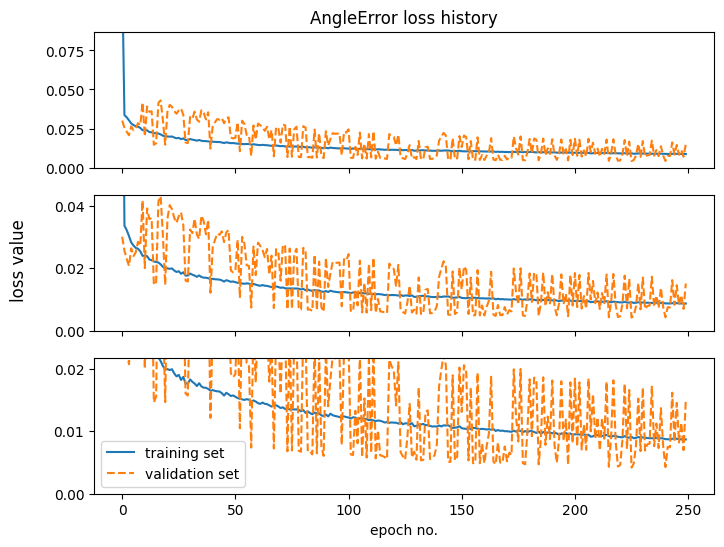

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
def make_dataframe(fit_history):
    df = pd.DataFrame(fit_history.history)
    df['epoch'] = fit_history.epoch
    return df

def plot_loss_history(fit_history, title = "", threshold_multiplier = 10):

    df = make_dataframe(fit_history)

    train_1st_percentile = np.percentile(df['loss'].values, 1)
    val_1st_percentile = np.percentile(df['val_loss'].values, 1)
    print(f'1st percentile of train loss:       {train_1st_percentile:.4e}')
    print(f'1st percentile of validation loss:  {val_1st_percentile:.4e}')
    
    threshold = np.maximum(train_1st_percentile, val_1st_percentile)
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,6))
    axes[0].set_title(f"{title} loss history")
    for axis in axes:
        axis.set_ylim((0, threshold_multiplier*threshold))
        axis.plot(df['epoch'], df['loss'], label='training set')
        axis.plot(df['epoch'], df['val_loss'], linestyle='dashed', label='validation set')
        threshold_multiplier /= 2
    axes[-1].legend(loc="lower left")
    axes[-1].set_xlabel("epoch no.")
    fig.supylabel("loss value")

plot_loss_history(history, "AngleError")